Este projeto é uma análise exploratória do dataset Intel Image Classification, disponível no Kaggle. O dataset contém 25 mil imagens de 6 classes diferentes, sendo elas: buildings, forest, glacier, mountain, sea e street. O objetivo é classificar as imagens de acordo com a classe a qual pertencem.



In [3]:
import numpy as np
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Flatten, Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
import seaborn as sns
import matplotlib.pyplot as plt


2023-12-10 19:15:26.027877: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-10 19:15:26.080349: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-10 19:15:26.080370: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-10 19:15:26.082266: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-10 19:15:26.089703: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-10 19:15:26.090462: I tensorflow/core/platform/cpu_feature_guard.cc:1

### Verificando se existe GPU disponível

In [4]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

Num GPUs Available:  0


### Preparing Dataset

In [5]:
train_dataset, validation_dataset = keras.utils.image_dataset_from_directory('./seg_train',
                                                        #  batch_size=64,
                                                         class_names=['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'],
                                                         image_size=(150, 150),
                                                         validation_split=0.2,
                                                         seed=123,
                                                         subset='both',
                                                         label_mode='categorical')


# prediction_dataset = keras.utils.image_dataset_from_directory('./seg_pred', batch_size=64,  shuffle=True, image_size=(150, 150))

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Using 2806 files for validation.


## Exploratore Analysis

Como veremos abaixo, o dataset é composto por imagens de 150x150 pixels, coloridas e com 3 canais (RGB). Além disso, o dataset é balanceado, ou seja, possui a mesma quantidade de imagens para cada classe.
Exibiremos algumas imagens do dataset para melhor entendimento.



In [4]:
# # Describe some characteristics of the dataset.
# print(train_dataset.class_names)
# print(validation_dataset.class_names)
# print(train_dataset)
# print(validation_dataset)

# # Visualize one of the images in the dataset.
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 10))
# for images, labels in train_dataset.take(1):
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(train_dataset.class_names[labels[i]])
#         plt.axis("off")

### Model Definition

We opted in to store all the neural newtorks in a dictionary, so we can easily access them later on.


In [6]:
neural_networks = []

neural_networks.append({
        'description': 'Conv2D',
        'model': Sequential([
                    Convolution2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)),
                    Flatten(input_shape=(150, 150, 3)),
                    Dense(units=6, activation='softmax')
                    ]
                ),
        'epochs': 7,
        'optimizer': Adam(learning_rate=0.0001),
        'loss_function': 'categorical_crossentropy',
        'accuracy': None,
        'loss': None,
        'training_time': None,
        "history": None
    }
)

neural_networks.append(
    {
        'description': 'Conv2D_MaxPooling_Conv2D',
        'model': Sequential([
                    Convolution2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)),
                    MaxPooling2D(pool_size=(2, 2)),
                    Convolution2D(filters=32, kernel_size=(3, 3), activation='relu'),
                    Flatten(input_shape=(150, 150, 3)),
                    Dense(units=6, activation='softmax')
                    ]
                ),
        'epochs': 7,
        'optimizer': Adam(learning_rate=0.0001),
        'loss_function': 'categorical_crossentropy',
        'accuracy': None,
        'loss': None,
        'training_time': None,
        "history": None
    }
)

neural_networks.append(
    {
        'description': 'Conv2D_MaxPooling_Conv2D_MaxPooling',
        'model': Sequential([
                    Convolution2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)),
                    MaxPooling2D(pool_size=(2, 2)),
                    Convolution2D(filters=32, kernel_size=(3, 3), activation='relu'),
                    MaxPooling2D(pool_size=(2, 2)),
                    Flatten(input_shape=(150, 150, 3)),
                    Dense(units=6, activation='softmax')
                    ]
                ),
        'epochs': 7,
        'optimizer': Adam(learning_rate=0.0001),
        'loss_function': 'categorical_crossentropy',
        'accuracy': None,
        'loss': None,
        'training_time': None,
        "history": None
    }
)

# Appending VGG16
from keras.applications.vgg16 import VGG16
vgg16 = VGG16(include_top=False, input_shape=(150, 150, 3))
vgg16.trainable = False
neural_networks.append(
    {
        'description': 'VGG16',
        'model': Sequential([
                    vgg16,
                    Flatten(input_shape=(150, 150, 3)),
                    Dense(units=6, activation='softmax')
                    ]
                ),
        'epochs': 7,
        'optimizer': Adam(learning_rate=0.0001),
        'loss_function': 'categorical_crossentropy',
        'accuracy': None,
        'loss': None,
        'training_time': None,
        "history": None
    }
)

In [7]:
for nn in neural_networks:
    model = nn['model']
    model.compile(optimizer=nn['optimizer'], loss=nn['loss_function'], metrics=['accuracy'])

### Model Training

In [8]:
for nn in neural_networks:
    model = nn['model']

    # If file exists, load it from /models folder
    try:
        model.load_weights('models/' + nn['description'] + '.h5')
        print('Loaded model from disk')
    except:
        print('No model found')


        nn["history"] = model.fit(
            train_dataset,
            epochs=nn['epochs'],
            verbose=2,
            validation_data=validation_dataset
        )
    
        model.save('models/' + nn['description'] + '.h5')


Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk


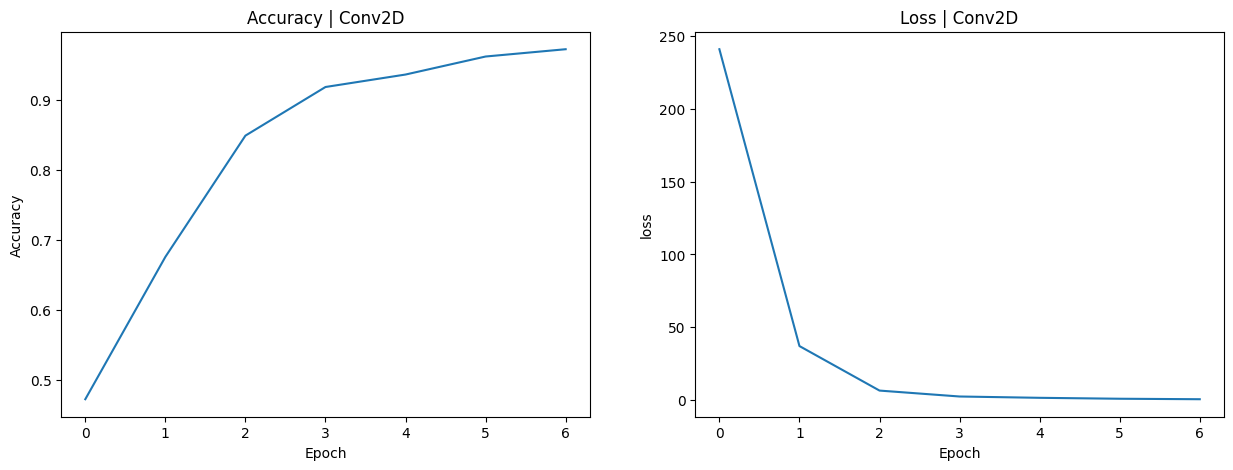

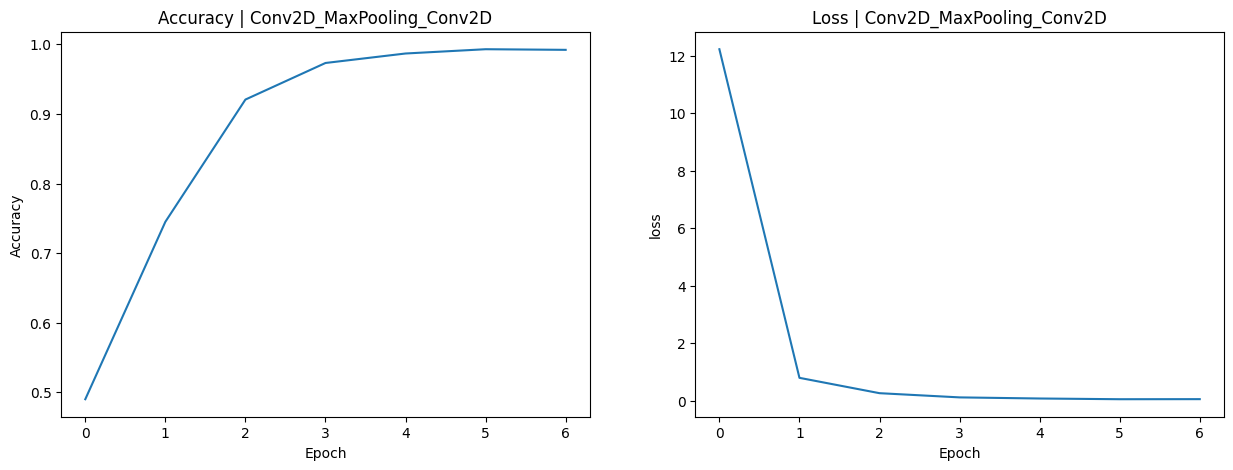

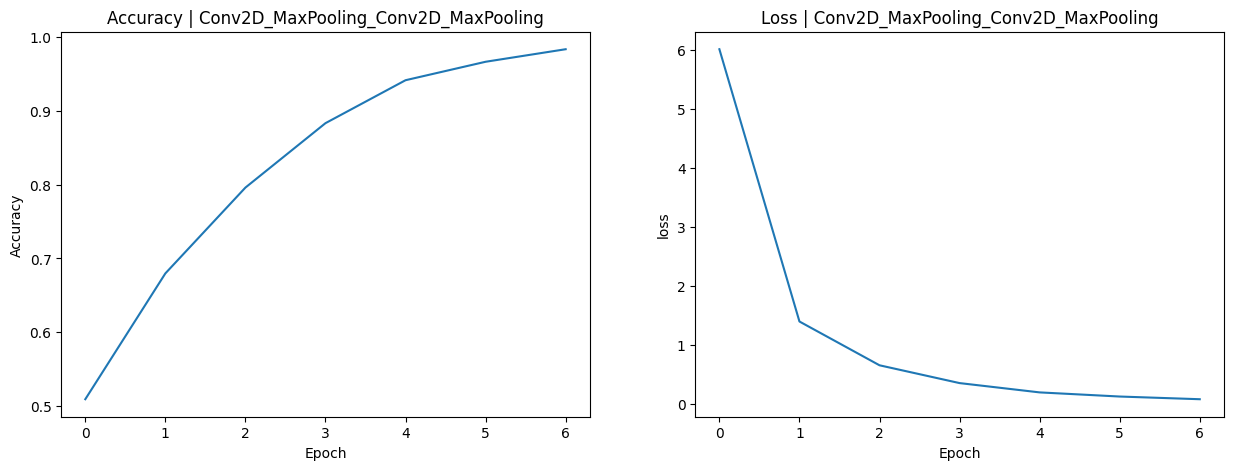

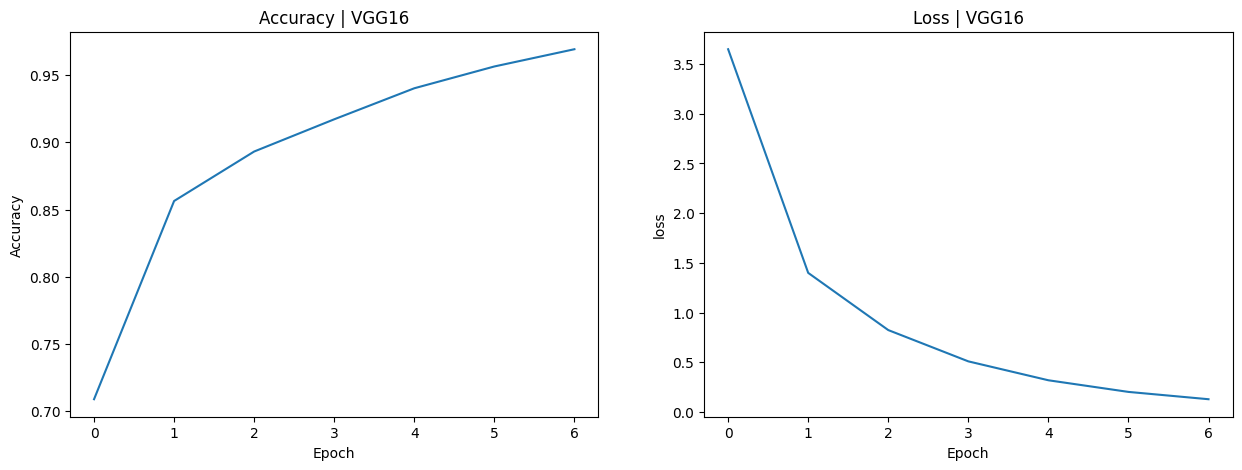

In [8]:
for nn in neural_networks:
    # model = nn['model']


    # Figure with 2 images side by side
    fig = plt.figure(figsize=(15, 5))
    fig.add_subplot(1, 2, 1)
    plt.plot(nn["history"].history['accuracy'])
    plt.title(f'Accuracy | {nn["description"]}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    fig.add_subplot(1, 2, 2)
    plt.plot(nn["history"].history['loss'])
    plt.title(f'Loss | {nn["description"]}')
    plt.ylabel('loss')
    plt.xlabel('Epoch')
    plt.show()


### Model Prediction

In [9]:
# for nn in neural_networks:
#     model = nn['model']
#     print(model.summary())
#     model.evaluate(validation_dataset, verbose=1)

# predictions = model.predict(prediction_dataset, verbose=2)

## Visualizing

In [13]:
from sklearn.metrics import confusion_matrix


test_dataset = keras.utils.image_dataset_from_directory('./seg_test',
                                                              batch_size=64,
                                                              class_names=['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'],
                                                              image_size=(150, 150),
                                                              shuffle=True,
                                                              label_mode='categorical')


for nn in neural_networks:
    model = nn['model']        


    y_true = []
    y_predicted = []

    for batch in test_dataset:

        predicted_batch = model.predict(batch[0], verbose=2)
        predicted_batch = np.argmax(predicted_batch, axis=1)
        y_predicted.append(predicted_batch)


        for label in batch[1]:
            y_true.append(label)

    y_true = np.argmax(y_true, axis=1)


    y_predicted = np.concatenate(y_predicted, axis=0)





    # predictions = model.predict(test_dataset, verbose=2)
    # predictions = np.argmax(predictions, axis=1)
#     # y_true = [test_dataset.class_names[np.argmax(y)] for x, y in test_dataset]
#     y_true = np.argmax(y_true, axis=1)
    nn["confusion_matrix"] = confusion_matrix(y_true, y_predicted)
#     nn["confusion_matrix"] = confusion_matrix(y_true, y_pred, labels=['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'])

#     # cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

Found 3000 files belonging to 6 classes.
2/2 - 0s - 166ms/epoch - 83ms/step
2/2 - 0s - 91ms/epoch - 46ms/step
2/2 - 0s - 93ms/epoch - 46ms/step
2/2 - 0s - 91ms/epoch - 46ms/step
2/2 - 0s - 93ms/epoch - 46ms/step
2/2 - 0s - 89ms/epoch - 45ms/step
2/2 - 0s - 90ms/epoch - 45ms/step
2/2 - 0s - 83ms/epoch - 41ms/step
2/2 - 0s - 88ms/epoch - 44ms/step
2/2 - 0s - 93ms/epoch - 47ms/step
2/2 - 0s - 93ms/epoch - 46ms/step
2/2 - 0s - 85ms/epoch - 42ms/step
2/2 - 0s - 91ms/epoch - 45ms/step
2/2 - 0s - 87ms/epoch - 44ms/step
2/2 - 0s - 96ms/epoch - 48ms/step
2/2 - 0s - 92ms/epoch - 46ms/step
2/2 - 0s - 96ms/epoch - 48ms/step
2/2 - 0s - 98ms/epoch - 49ms/step
2/2 - 0s - 115ms/epoch - 57ms/step
2/2 - 0s - 130ms/epoch - 65ms/step
2/2 - 0s - 101ms/epoch - 50ms/step
2/2 - 0s - 95ms/epoch - 48ms/step
2/2 - 0s - 92ms/epoch - 46ms/step
2/2 - 0s - 93ms/epoch - 47ms/step
2/2 - 0s - 105ms/epoch - 53ms/step
2/2 - 0s - 103ms/epoch - 51ms/step
2/2 - 0s - 99ms/epoch - 49ms/step
2/2 - 0s - 98ms/epoch - 49ms/step
2

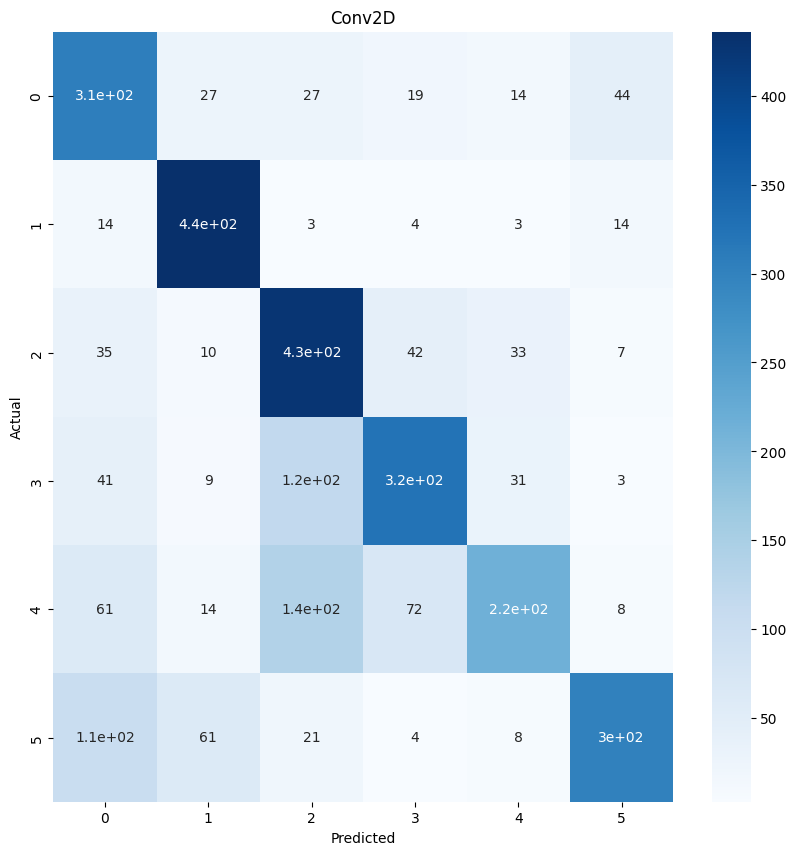

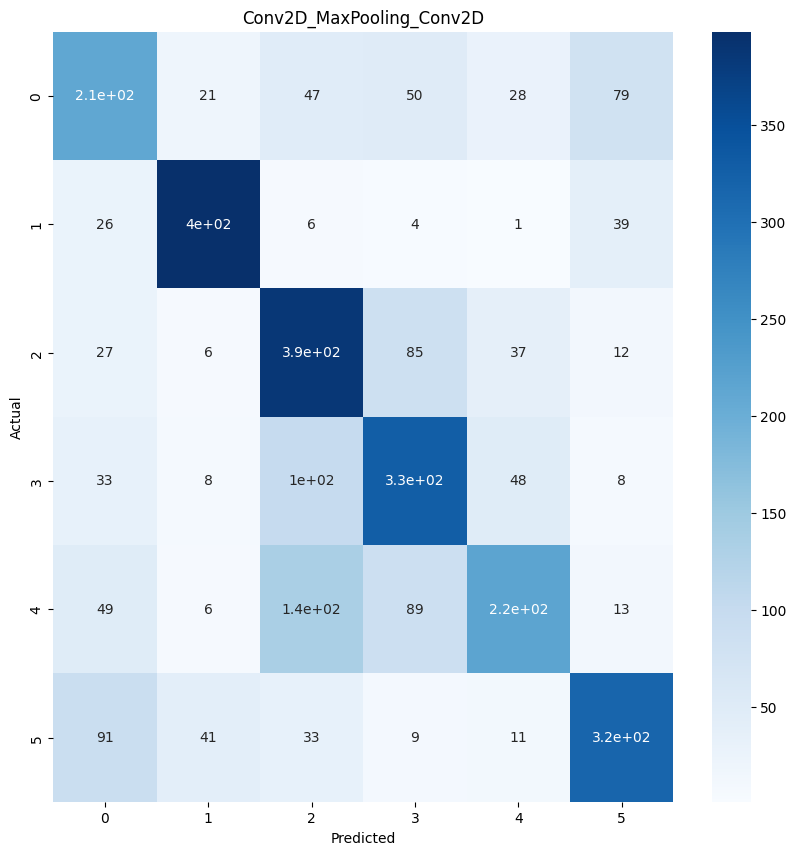

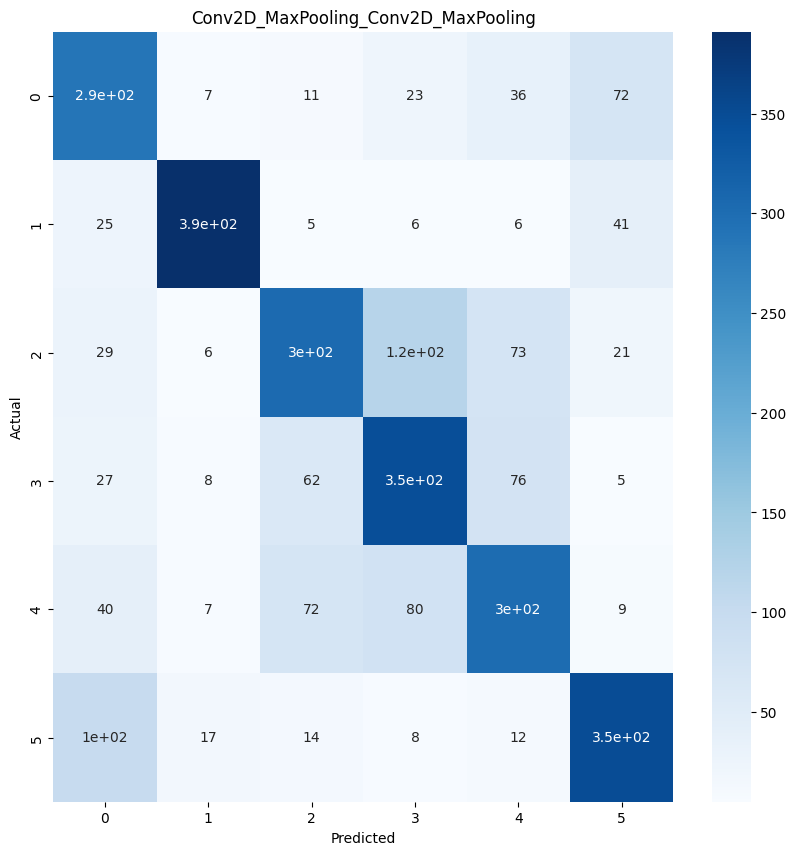

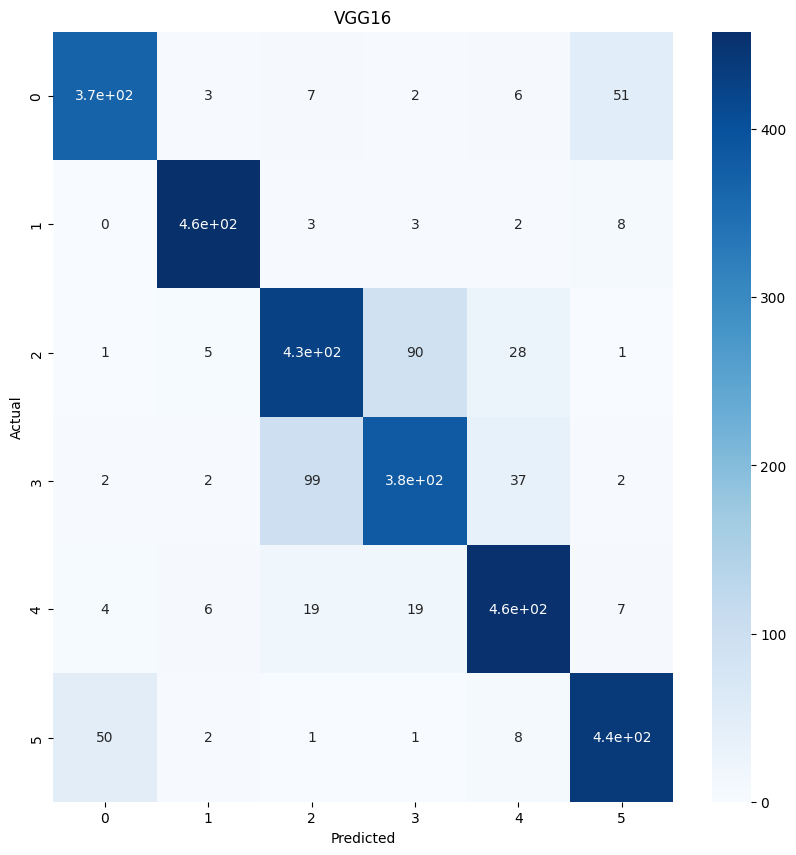

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

for nn in neural_networks:
    cm = nn["confusion_matrix"]
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, cmap=plt.cm.Blues)
    plt.title(nn["description"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(nn["description"])
    plt.show()

